# English Premier League Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib.patches as mpatches
import random
import warnings
import platform
import time
import re

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import naive_bayes
from sklearn import preprocessing

%matplotlib inline
warnings.filterwarnings("ignore")

# 1. Introduction/ Motivation
Every year in English Premier League (EPL), all clubs are striving to get into the top 4 in the league so that they can participate in the Champions League, which is the biggest competition in Europe. We have some ideas about what a team should do to win a match such as accurate passing, high pressure, more shots on target, etc… As a Data science enthusiast and a huge soccer fan, I was curious to see if I can prove or find out what features are actually important to win a match. This could make a confident statement about what a team has to focus on to be in the top 4. In addition, it could help to predict what teams are highly likely to be in the top 4 using machine learning models.

Data was collected from EPL official website by web scraping(https://github.com/hyunilyoo/epl-webscraper), and splited into two groups, which are teams that are and are not in the top 4  as "Top 4" and "Below 4". Based on Exploratory Data Analysis, there are features that are significantly different between two groups. In contrast, there are features that are similar between two groups but give interesting insights, for example the number of crosses are higher in Top 4 but the cross accuracy is actually lower than Below 4. 

Based on EDA, there are 10 features, which are ‘Big chance created’, ‘Clearance’, 'Goal conceded per match', 'Goal per match', 'Pass per game', 'Shot on target', 'Won', 'Lost', 'Drawn', and 'Points', have related with getting into the top 4 in the league. 

To evaluate the features, I make several baseline models with different algorithms and compare them with a model that contains factors that are from EDA and a model with every feature. After the comparison, Random Forest model is the best model among others and achieves 96% in accuracy  and 0.95 in F1 score.

More details are provided in this notebook.

# 2. Dataset  
**Source:** Data is gathered by web scraping on EPL official website.  
**Period:** From 1993 to 2020  
**Features:** Total 23 columns and 566 rows  
**Characteristics:** Dataset is composed into two tables. One with final results of its season (it’s called “table.csv”) and one with clubs’ statistics (“club_statistics.csv”). “Table.csv” has all data from 1993 to 2020; however, “club_statistics.csv” missing many factors from 1993 to 2006 due to the data gathering method that EPL had applied in matches. More details are in this link: https://www.premierleague.com/stats/clarification

In [2]:
# load dataset
if platform.system() == 'Windows':
    tables = pd.read_csv('tables_crawler/tables_crawler/spiders/tables.csv')
    clubstats = pd.read_csv('clubstats_crawler/clubstats_crawler/spiders/clubstats.csv')
else:
    tables = pd.read_csv('data/tables.csv')
    clubstats = pd.read_csv('data/clubstats.csv')

### Overview of dataset

In [3]:
tables.head()

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Liverpool,1,66,21,1,82,1,27
1,Manchester City,3,68,31,7,57,2,18
2,Leicester City,5,58,28,8,53,3,16
3,Chelsea,6,51,39,9,48,4,14
4,Manchester United,9,44,30,8,45,5,12


In [4]:
clubstats.head()

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,season,shooting_accuracy,shot_on_target,tackle_success
0,"1,853",38,519,Arsenal,548,22%,1.29,1.43,258,84%,507.11,2019/20,35%,109,58%
1,"2,489",72,762,Arsenal,605,21%,1.34,1.92,412,83%,547.50,2018/19,36%,170,60%
2,"2,660",81,829,Arsenal,572,21%,1.34,1.95,427,84%,619.05,2017/18,39%,234,68%
3,"2,762",55,838,Arsenal,697,22%,1.16,2.03,536,84%,563.00,2016/17,36%,201,70%
4,"2,785",88,849,Arsenal,754,25%,0.95,1.71,734,84%,559.18,2015/16,37%,211,73%


# 3. Data Preprocessing
- Change into proper data types  
- Handling NA values

In [5]:
tables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   club_name     566 non-null    object
 1   drawn         566 non-null    int64 
 2   goal          566 non-null    int64 
 3   goal_against  566 non-null    int64 
 4   lost          566 non-null    int64 
 5   points        566 non-null    int64 
 6   position      566 non-null    int64 
 7   won           566 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 35.5+ KB


**"tables" is already in proper data types. Also no NA values.**

In [6]:
clubstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   aerial_battles           566 non-null    object 
 1   big_chance_created       566 non-null    int64  
 2   clearance                566 non-null    object 
 3   club_name                566 non-null    object 
 4   cross                    566 non-null    object 
 5   cross_accuracy           566 non-null    object 
 6   goal_conceded_per_match  566 non-null    float64
 7   goal_per_match           566 non-null    float64
 8   interceptions            566 non-null    int64  
 9   pass_accuracy            566 non-null    object 
 10  pass_per_game            566 non-null    float64
 11  season                   566 non-null    object 
 12  shooting_accuracy        566 non-null    object 
 13  shot_on_target           566 non-null    int64  
 14  tackle_success           5

**"clubstats" has a few features that are incorrectly formatted.**

In [7]:
# Change to proper data types
clubstats['cross_accuracy'] = clubstats['cross_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['pass_accuracy'] = clubstats['pass_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['shooting_accuracy'] = clubstats['shooting_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['tackle_success'] = clubstats['tackle_success'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['aerial_battles'] = clubstats['aerial_battles'].str.replace(',','').astype('int')
clubstats['clearance'] = clubstats['clearance'].str.replace(',','').astype('int')
clubstats['cross'] = clubstats['cross'].str.replace(',','').astype('int')

# In 'clubstats' AFC Bournemouth is named as it is, but in 'tables' it is named as 'Bournemouth'.
# So in order to join the two data frames, the club_name for AFC Bournmouth has to be changed.
clubstats['club_name'][53] = 'Bournemouth'
clubstats['club_name'][54] = 'Bournemouth'
clubstats['club_name'][55] = 'Bournemouth'
clubstats['club_name'][56] = 'Bournemouth'
clubstats['club_name'][57] = 'Bournemouth'

Need to join two tables, but there is no column that indicate what season it is on 'tables'.  Data were scraped descending order, which is 2019 to 1992, we just need to add the information on 'tables'.

In [8]:
season_info = clubstats[clubstats['club_name'] == "Arsenal"]['season']
seasons = []

for i in range(len(season_info)):
    if i < 25:
        seasons.append([season_info[i],] * 20)
    else:
        seasons.append([season_info[i],] * 22)

seasons_flat = [season for sub_season in seasons for season in sub_season]
tables['season'] = seasons_flat

# Join two data frames
data = pd.merge(tables, clubstats, on=['club_name', 'season'])

# To get total number of games
data['total_games'] = data['won'] + data['drawn'] + data['lost']

# Add top4 indicator 
data['is_top4'] = data['position'].apply(lambda x: 1 if (x <= 4) else 0)

# Since I want to predict Top 4 for season 2019/20, I will exclude this season.
current_season = data[data['season'] == '2019/20']
past_seasons = data[data['season'] != '2019/20'].reset_index(drop=True)

# 4 .Exploratory Data Analysis 

In [9]:
# Visual parameters
t4_color = '#3d195b'
b4_color = '#c9d6df'
b_color = '#f7f7f7'
seaborn_color = [b4_color, t4_color]
sns.set_palette(sns.color_palette(seaborn_color))
t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b4_legend = mpatches.Patch(color=b4_color, label='Below 4', edgecolor='black')

# Seperate into two groups
top4 = past_seasons[past_seasons['is_top4'] == 1]
below4 = past_seasons[past_seasons['is_top4'] == 0]

## 4.1 Table features
There are eight features in the table dataset. Every feature is analyzed except “position”. In this dataset, we can find out the thresholds that how many wins, loses, draws, points, goals, and goals against a team can have to be in the top 4.

### - Wins, Loses, Draws

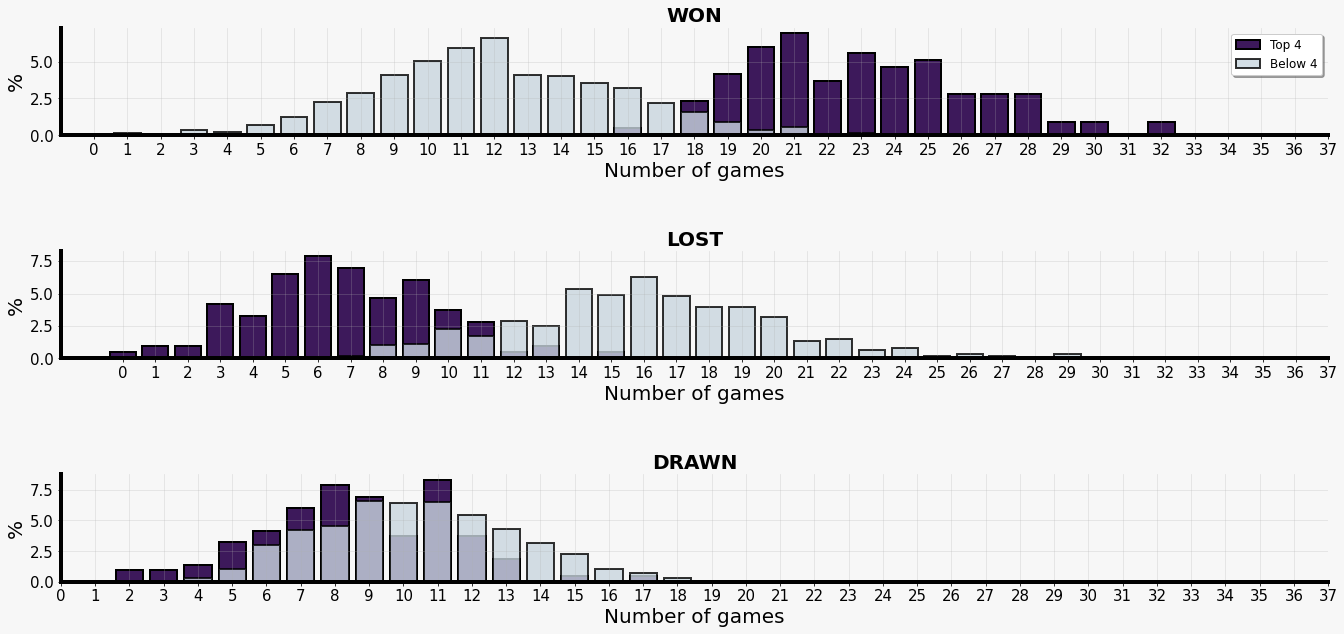

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))
cols = ['won', 'lost', 'drawn']

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = top4[col].value_counts().values
    b4_index = below4[col].value_counts().index
    b4_values = below4[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2, label='Top 4')
    ax.flatten()[i].bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=2, label='Below 4')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 38, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)
    ax.flatten()[i].set_xlabel('Number of games', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
        
    

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

The figure above is showing distributions of the number of win, lost, and draw. We can see if a team has less than 18 wins or more than 11 losts, a team is highly likely to not be in the Top 4. Interestingly, it seems like number of draws are pretty similar between two groups.

### - Points

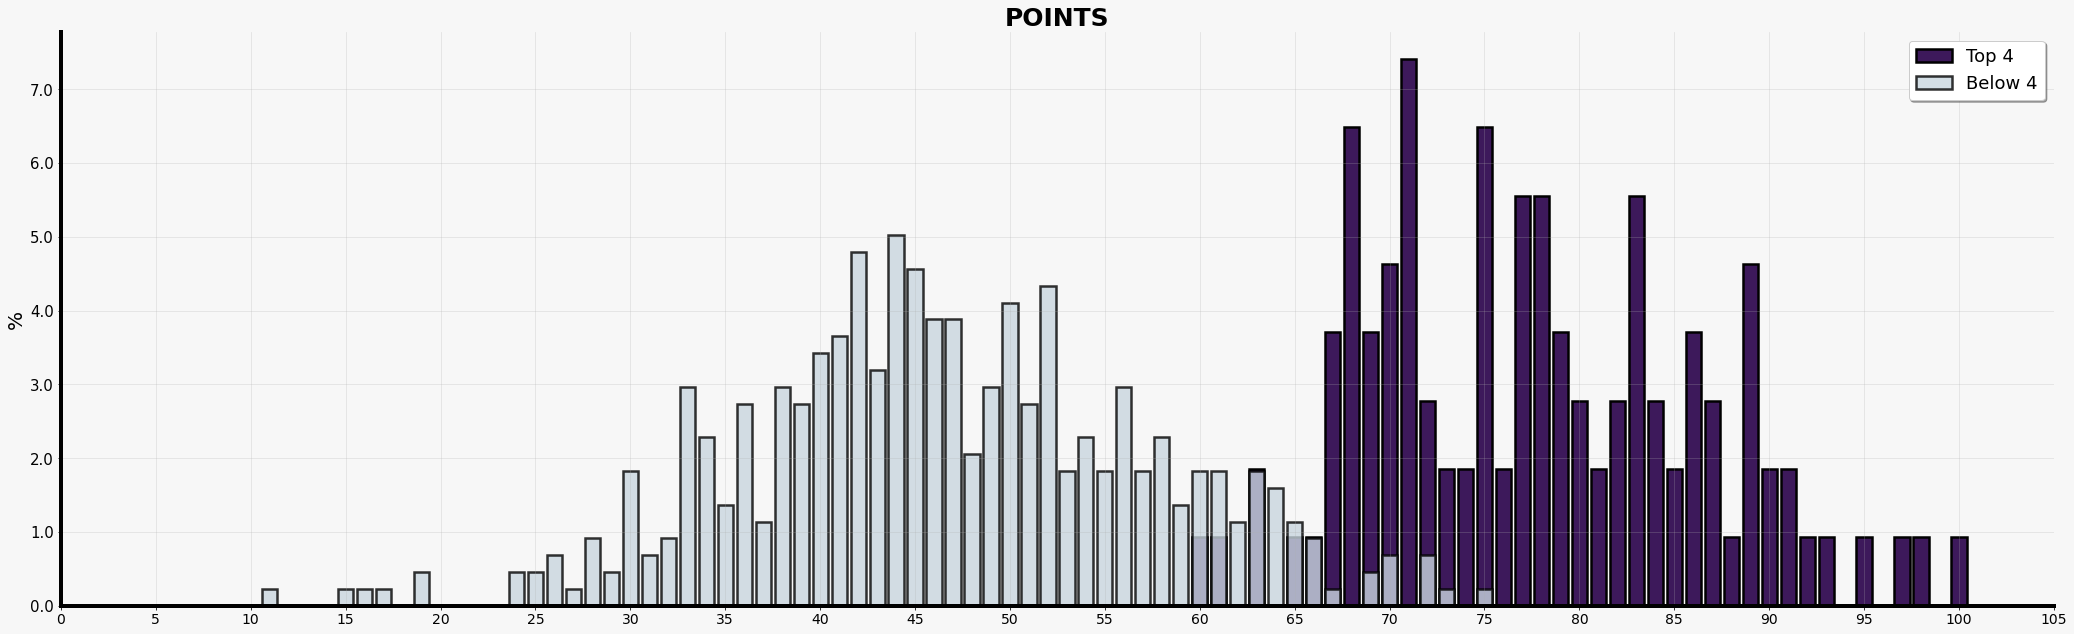

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
col = 'points'

t4_index = top4[col].value_counts().index
t4_values = top4[col].value_counts().values
b4_index = below4[col].value_counts().index
b4_values = below4[col].value_counts().values

ax.bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2.5, label='Top 4')
ax.bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=2.5, label='Below 4')

ax.grid(which='major', axis='x', zorder=0, alpha=0.3)
ax.grid(which='major', axis='y', zorder=0, alpha=0.3)

ax.set_xticks(np.arange(0, 110, 5))
ax.set_title(col.upper(), weight='bold', fontsize=25)
ax.set_ylabel('%', fontsize=20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_facecolor(b_color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.legend(loc=1, shadow=True, fontsize=18)

fig.set_facecolor(b_color)
fig.tight_layout(pad=5)
plt.show()

For points, when a team gets lower than 60 points, the probability of getting into Top 4 gets significantly low. 

### - Goal, Goal Against

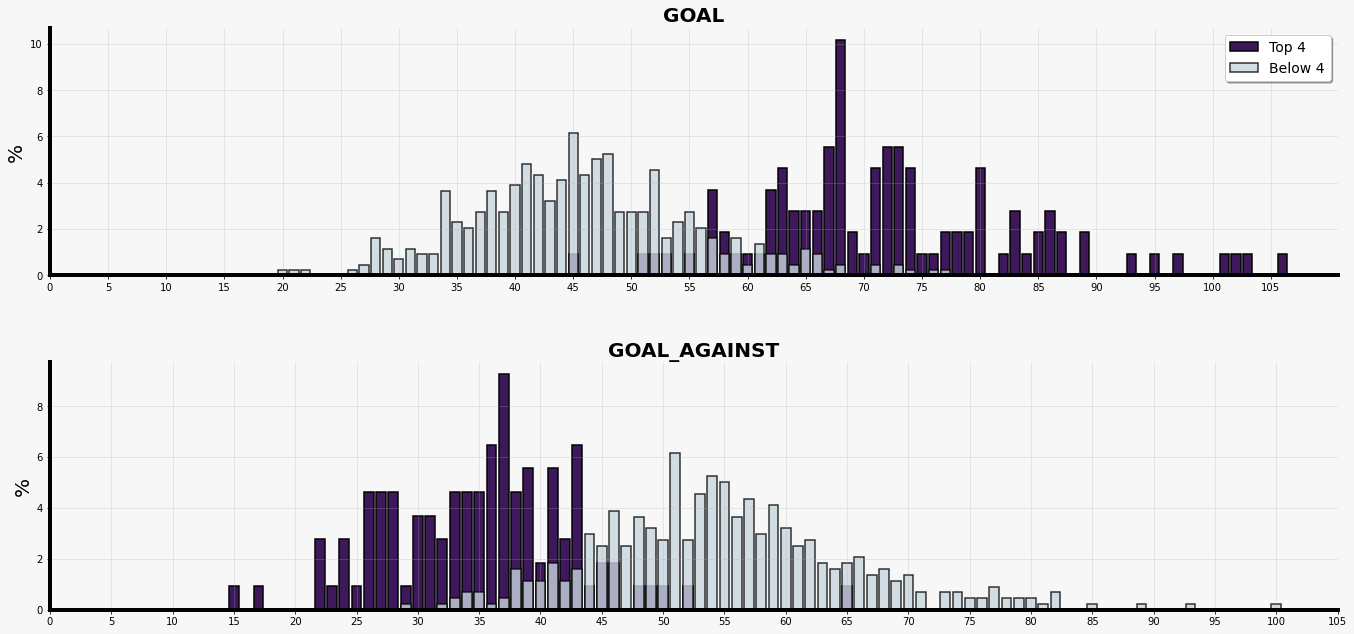

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
cols = ['goal', 'goal_against']

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = top4[col].value_counts().values
    b4_index = below4[col].value_counts().index
    b4_values = below4[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=1.5, label='Top 4')
    ax.flatten()[i].bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=1.5, label='Below 4')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 110, 5))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=14)

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

Scoring goals and conceding goals also look like there are difference between the groups. In this case, when a team scores less than 50 goals or concedes more than 43 goals, a team will save a hard time to get into Top 4.

## 4.2 Table features throughout the Seasons
Trend of soccer tactics are changing every year or so. Therefore, comparing the features by each season might give some insights whether distribution of the features got changed overtime.

In [13]:
seasons = np.flip(data['season'].unique())

t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b4_legend = mpatches.Patch(color=b4_color, label='Below 4', edgecolor='black')

### - Wins, Loses, Draws

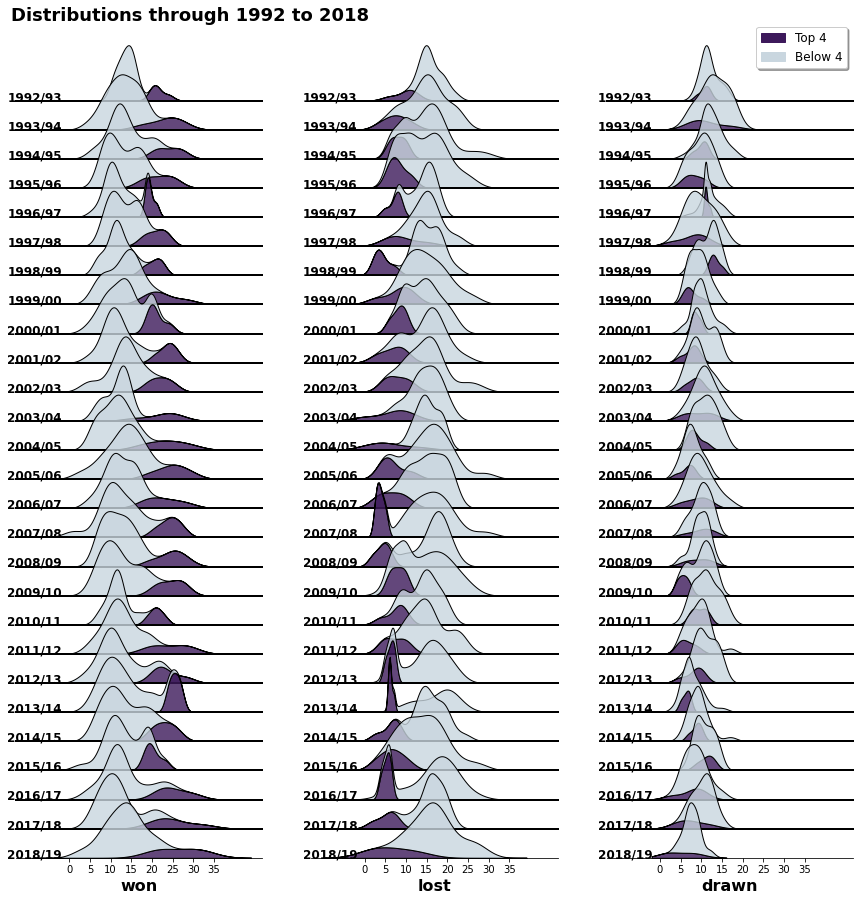

In [14]:
cols = ['won', 'lost', 'drawn']

fig, ax = plt.subplots(len(seasons[:-1]), 3, figsize=(15, 15), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=data[data['season'] == season], x=col, hue='is_top4',  alpha=.8, 
                    edgecolor='black', multiple='stack', legend=False, ax=ax[j, i])
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
            ax[j, i].set_xticks(np.arange(0, 40, 5))
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

The figures above are distribution plots throughout the seasons for the number of win, lost and draw games. 

Based on the plots, the distributions of won and lost were changed time to time, but it did not consistently change throughout the years. In some seasons, "Top 4" teams has a wide distribution of won and lost. That means there is a team that outperformed the others by a lot in those seasons. Therefore, we can say the number of wins and losts did not change much for the past 26 years, and they are constantly far apart from each other. However, if you look at draw games, Top 4 and Below 4 are very close to each other, and sometimes Top 4 has more draw games than Below 4. 

To sum up, we can conclude that there is no difference in the number of results throughout the years, and the number of  wins and losts are always distinguishable between Top 4 and Below 4, but the number of draw games can be very similar to each other.

### - Points

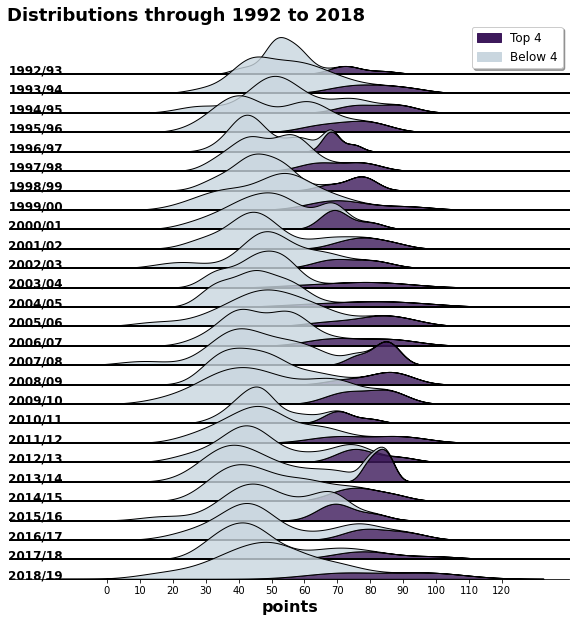

In [15]:
fig, ax = plt.subplots(len(seasons[:-1]), 1, figsize=(10, 10), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for j, season in enumerate(seasons[:-1]):
    sns.kdeplot(data=data[data['season'] == season], x='points', hue='is_top4',  alpha=.8, 
                edgecolor='black', multiple='stack', legend=False, ax=ax[j])
    
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].grid(False)
    ax[j].get_yaxis().set_visible(False)
    ax[j].set_facecolor('None')
    
    if j != len(seasons[:-1])-1:
        ax[j].spines['bottom'].set_linewidth(2)
        ax[j].get_xaxis().set_visible(False)
        ax[j].set_xticks(np.arange(0,130,10))
        ax[j].text(-30, 0, season, fontweight='bold', fontsize=12)
    else:
        ax[j].get_xaxis().set_visible(True)
        ax[j].set_xticks(np.arange(0,130,10))
        ax[j].set_xlabel('points', fontsize=16, fontweight='bold')
        ax[j].text(-30, 0, season, fontweight='bold', fontsize=12)

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

The plot shows there is no change in points throughout the years in both groups (but we can observe seasons with wide distributions that similar to the previous plot). Based on the observation, a team needs at least 60 points to increase the chance to be in the top 4. Otherwise, the probability of a team getting into the top 4 is very low. 

### - Goals and Goals Against

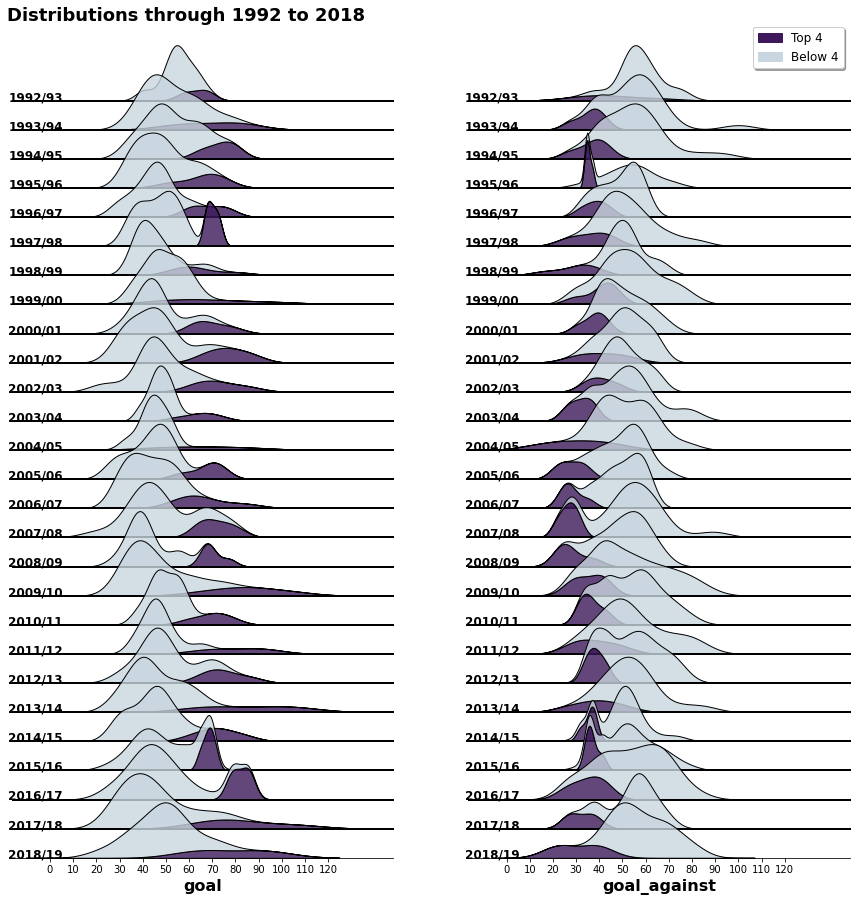

In [16]:
cols = ['goal', 'goal_against']

fig, ax = plt.subplots(len(seasons[:-1]), 2, figsize=(15, 15), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=data[data['season'] == season], x=col, hue='is_top4',  alpha=.8, 
                    edgecolor='black', multiple='stack', legend=False, ax=ax[j, i])
        
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-18, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-18, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')
            ax[j, i].set_xticks(np.arange(0,130,10))

fig.legend(bbox_to_anchor=(0.9, 0.9), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

A similar phenomenon is observed here. There are seasons that have a wide distribution or narrow distribution for Top 4 team. And the overall trend of goal and goal_against did not change throughout the years.

As a result, Season did not affect the other features significantly but just some seasons there was a team that outperformed others by far so that it even makes a difference among Top 4 teams.

## 4.3 Club statistics

**The data before season 2006 have many features that are zero due to the reason as follows:**  
"When the Premier League began in 1992/93, only a basic level of match data was gathered. Over time this has increased and since 2006/07 a wide range of statistics are now provided. The information below shows a breakdown of the statistics on the Premier League website and the season this data originated." **from EPL offical website, https://www.premierleague.com/stats/clarification**

In [17]:
features = ['aerial_battles', 'big_chance_created', 'clearance', 'cross', 'cross_accuracy', 'goal_conceded_per_match', 
            'goal_per_match', 'interceptions', 'pass_accuracy', 'pass_per_game', 'shooting_accuracy', 'shot_on_target', 'tackle_success']

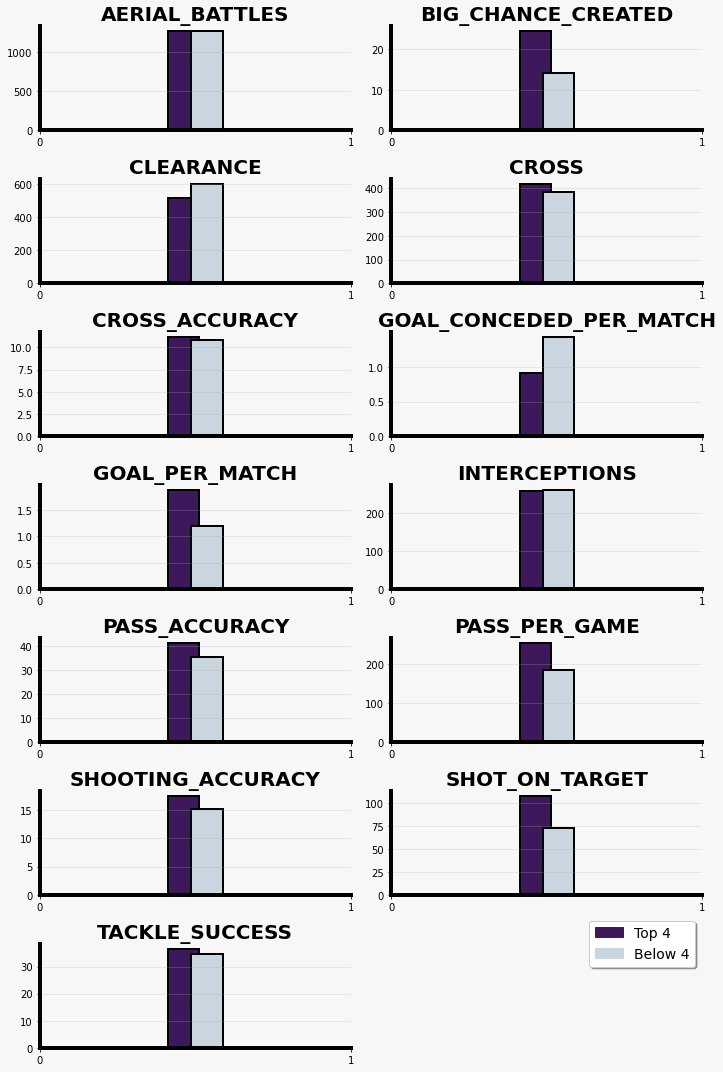

In [18]:
fig, ax = plt.subplots(7, 2, figsize=(10,15))
cols = features

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = np.mean(top4[col])
    b4_index = below4[col].value_counts().index
    b4_values = np.mean(below4[col])

    ax.flatten()[i].bar(x=0.5-0.075/2, height=t4_values, width=0.1, color=t4_color, edgecolor='black', linewidth=2)
    ax.flatten()[i].bar(x=0.5+0.075/2, height=b4_values, width=0.1, color=b4_color, edgecolor='black', linewidth=2)

    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)

    ax.flatten()[i].set_xticks(np.arange(0,2,1))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)

    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)

ax.flatten()[-1].set_facecolor(b_color)
ax.flatten()[-1].grid(which='major', axis='x', zorder=0, color=b_color)
ax.flatten()[-1].grid(which='major', axis='y', zorder=0, color=b_color)
ax.flatten()[-1].spines['top'].set_visible(False)
ax.flatten()[-1].spines['right'].set_visible(False)
ax.flatten()[-1].spines['bottom'].set_linewidth(False)
ax.flatten()[-1].spines['left'].set_linewidth(False)
ax.flatten()[-1].get_xaxis().set_visible(False)
ax.flatten()[-1].get_yaxis().set_visible(False)

fig.set_facecolor(b_color)
fig.legend(bbox_to_anchor=(0.98, 0.15), handles=[t4_legend, b4_legend], shadow=True, fontsize=14)
fig.tight_layout()
plt.show()

Now let’s take a look at club statistics. 

For  Big change created, Top 4 obviously has a much higher value than Below 4. In contrast, Below 4 has a much higher Goal conceded per match value than Top 4. These two features may be too obvious, a higher value in Big chance created means a team has a higher chance scoring a goal and a higher value in Goal conceded per match literally means a team has a higher rate to get scored. 

Features that are not directly related to score show interesting insights. It looks like Aerial battles is not different between Top 4 and Below 4, which means that the number of Aerial battles does not influence the match enough to change the outcome of a match. For Clearance Top 4 has less value than Below 4. This could mean that Top 4 has fewer situations where they need to clear the ball in defensive situations; thus, more clearances could indicate that a team is less dominant than another team during the match. For Cross and Cross accuracy, they both have a similar level of accuracy in crossing, but Top 4 tends to have more crossing than Below 4, which means they are more aggressive in attacking situations.

Goal per match shows that Top 4 has much higher value than Below 4 and the same insight goes with Shot on target, higher value in Shot on target means it has a better chance in scoring a goal. There is less difference in Shooting accuracy than Shot on target. Shooting accuracy means accuracy of shooting that are shots on goal (target). Therefore, this indicates that Below 4 tries less shootings or they have less attacking situations than Top 4. Similar relationships can be found in Pass per game and Pass accuracy. Top 4 has higher in both features and there is less difference in accuracy. Lastly, Interceptions and Tackle success do not affect an outcome of a match based on its plots. 

## 4.4 Additional: Correlation among features

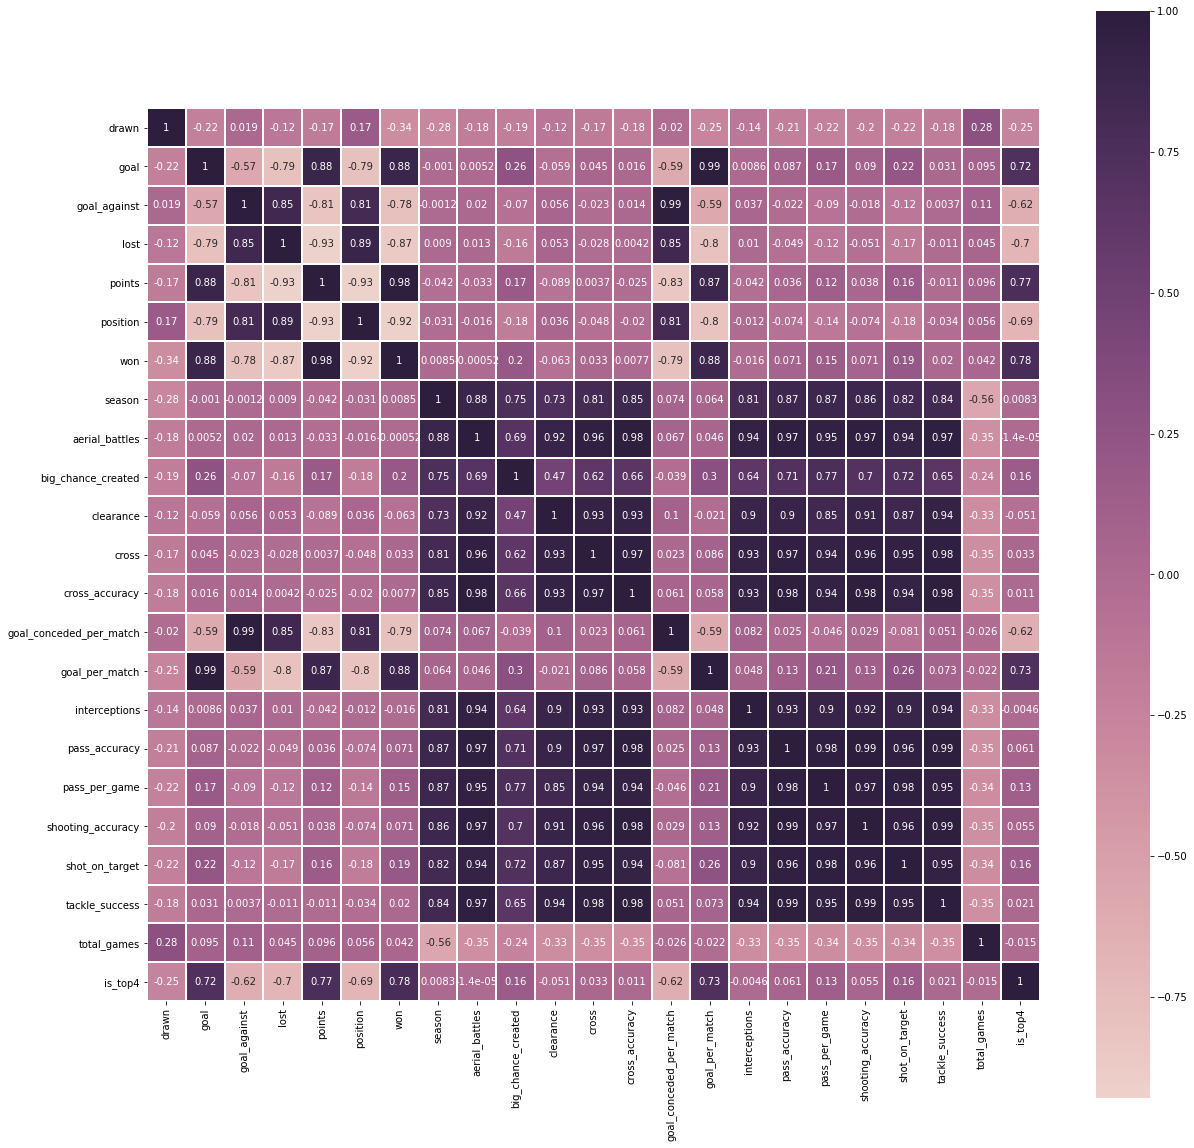

In [19]:
pattern = re.compile('/\d*')

past_seasons['season'] = past_seasons['season'].apply(lambda x: pattern.sub('', x))

past_seasons['season'] = past_seasons['season'].astype(int)

p_season_corr = past_seasons.corr()

plt.figure(figsize=(20,20))
sns.heatmap(p_season_corr, 
            mask=np.zeros_like(p_season_corr, dtype=np.bool), 
            annot=True, cmap=sns.cubehelix_palette(as_cmap=True), square=True, linewidths=0.1)
plt.show()

# 5. ML

## 5.1 Baseline model for "tables" and "clubstats" dataset. 

#### Baseline models with every feature
Need to think about which models to use since there are not many data points.  

"""  
If the training data is sufficiently large and the number of observations is higher as compared to the number of features, one can go for low bias/high variance algorithms like KNN, Decision trees, or kernel SVM.  

In general, small datasets require models that have low complexity (or high bias) to avoid overfitting the model to the data.  

ref: https://www.kdnuggets.com/2020/05/guide-choose-right-machine-learning-algorithm.html  
"""

#### Choosing the high bias models  due to small dataset
- Naive Bayes
- Linear SVM
- Logistic Regression

In [20]:
def train(X, y, X_valid, y_valid):
    nb = naive_bayes.GaussianNB()
    lsvm = LinearSVC(random_state=2021)
    logit = LogisticRegression(random_state=2021)
    
    nb.fit(X, y)
    lsvm.fit(X, y)
    logit.fit(X, y)
    
    nb_preds = nb.predict(X_valid)
    lsvm_preds = lsvm.predict(X_valid)
    logit_preds = logit.predict(X_valid)
    
    print((f'F1 Scores \n Naive Bayes: {f1_score(y_valid, nb_preds)} \n' 
           f' Linear SVM: {f1_score(y_valid, lsvm_preds)} \n' 
           f' Logitstic Regression: {f1_score(y_valid, logit_preds)}'))
    
    return [nb, lsvm, logit]


def plot_learning(X, y):
    nb = naive_bayes.GaussianNB()
    lsvm = LinearSVC(random_state=2021)
    logit = LogisticRegression(random_state=2021)
    
    models = [nb, lsvm, logit]
    
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    
    for i in range(3):
        train_sizes, train_score, valid_scores = learning_curve(models[i], X, y, cv=5)
        ax.flatten()[i].plot(train_sizes, np.mean(train_score, axis=1), 'o-', color=b4_color, label='Training')
        ax.flatten()[i].plot(train_sizes, np.mean(valid_scores, axis=1), 'o-', color=t4_color, label='CV')
        ax.flatten()[i].legend()
        ax.flatten()[i].set_title(f'{models[i]}')

### Creating two models for tables and club statistics

In [21]:
t_cols = list(tables.columns)
t_cols.append('is_top4')

c_cols = list(clubstats.columns)
c_cols.append('is_top4')

tables_train = data[t_cols]
clubstats_train = data[c_cols]
tables_train = tables_train.drop('club_name', axis=1)
clubstats_train = clubstats_train.drop('club_name', axis=1)


pattern = re.compile('/\d*')

tables_train['season'] = tables_train['season'].apply(lambda x: pattern.sub('', x))
clubstats_train['season'] = clubstats_train['season'].apply(lambda x: pattern.sub('', x))

tables_train['season'] = tables_train['season'].astype(int)
clubstats_train['season'] = clubstats_train['season'].astype(int)

tables_test = tables_train[tables_train['season'] == 2019]
clubstats_test = clubstats_train[clubstats_train['season'] == 2019]

num_match = tables_test[['won', 'drawn', 'lost']].apply(np.sum, axis=1)

for i, n in enumerate(num_match):
    tables_test.loc[i,['drawn', 'goal', 'goal_against', 'lost', 'points', 'won']] /= n

    
tables_train = tables_train.drop(tables_test.index, axis=0)
clubstats_train = clubstats_train.drop(clubstats_test.index, axis=0)

tables_train.loc[:, ['drawn', 'goal', 'goal_against', 'lost', 'points', 'won']] /= 38

# Shuffle the dataset
tables_train = tables_train.sample(frac=1, random_state=2021)
clubstats_train = clubstats_train.sample(frac=1, random_state=2021)


# Selected the periods that have non zero data for club statistics, which is from 2006/07 to 2019/20
clubstats_train = clubstats_train[clubstats_train['season'] > 2005]

### Create train, cv, and test set

In [22]:
# Split Train and Test set
X_club_train, X_club_test, y_club_train, y_club_test = train_test_split(clubstats_train.drop('is_top4', axis=1), 
                                                                        clubstats_train['is_top4'], test_size=0.4, 
                                                                        random_state=2021, stratify=clubstats_train['is_top4'])
X_table_train, X_table_test, y_table_train, y_table_test = train_test_split(tables_train.drop('is_top4', axis=1), 
                                                                            tables_train['is_top4'], test_size=0.4, 
                                                                            random_state=2021, stratify=tables_train['is_top4'])

# Split Test set for validation set
X_club_valid, X_club_test, y_club_valid, y_club_test = train_test_split(X_club_test, y_club_test, 
                                                                        test_size=0.5, random_state=2021, 
                                                                        stratify=y_club_test)
X_table_valid, X_table_test, y_table_valid, y_table_test = train_test_split(X_table_test, y_table_test, 
                                                                            test_size=0.5, random_state=2021, 
                                                                            stratify=y_table_test)

### For tables_train

In [23]:
t_nb, t_lsvm, t_logit = train(X_table_train, y_table_train, X_table_valid, y_table_valid)

F1 Scores 
 Naive Bayes: 0.9130434782608696 
 Linear SVM: 0.8235294117647058 
 Logitstic Regression: 1.0


### Visualize the learning

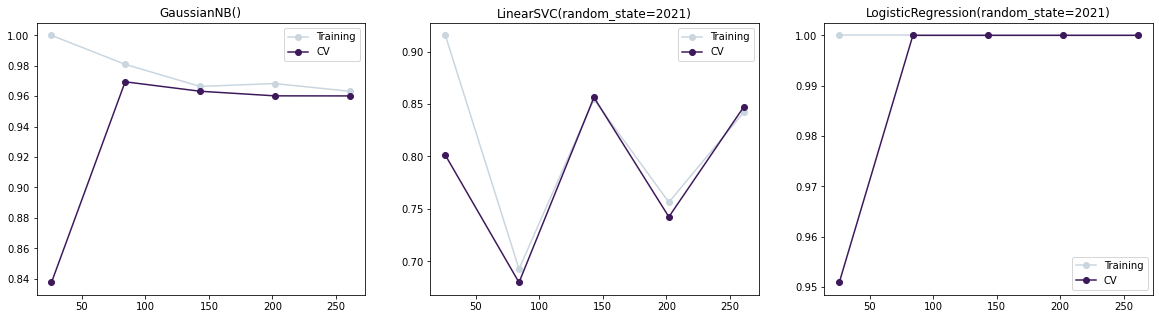

In [24]:
plot_learning(X_table_train, y_table_train)

Every model overfits a lot except Naive Bayes. This may due to small data points and not many features in the dataset.

### For clubstats_train

In [25]:
c_nb, c_lsvm, c_logit = train(X_club_train, y_club_train, X_club_valid, y_club_valid)

F1 Scores 
 Naive Bayes: 0.88 
 Linear SVM: 0.16666666666666669 
 Logitstic Regression: 0.9090909090909091


### Visualize the learning

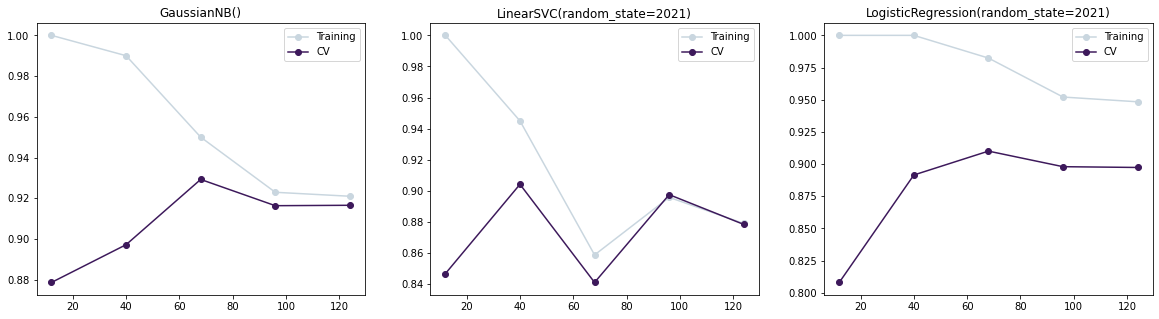

In [26]:
plot_learning(X_club_train, y_club_train)

### For tables_train & clubstats_train

In [27]:
tables_clubs = pd.concat([tables_train.drop('is_top4',axis=1), clubstats_train.drop('season', axis=1)], axis=1)
tables_clubs = tables_clubs.drop(tables_clubs[tables_clubs['season'] < 2006].index, axis=0)

# Split Train and Test set
X_tc_train, X_tc_test, y_tc_train, y_tc_test = train_test_split(tables_clubs.drop('is_top4', axis=1), tables_clubs['is_top4'], test_size=0.4, random_state=2021, stratify=tables_clubs['is_top4'])

# Split Test set for validation set
X_tc_valid, X_tc_test, y_tc_valid, y_tc_test = train_test_split(X_tc_test, y_tc_test, test_size=0.5, random_state=2021, stratify=y_tc_test)

In [28]:
tc_nb, tc_lsvm, tc_logit = train(X_tc_train, y_tc_train, X_tc_valid, y_tc_valid)

F1 Scores 
 Naive Bayes: 1.0 
 Linear SVM: 0.9166666666666666 
 Logitstic Regression: 0.8571428571428572


### Visualize the learning

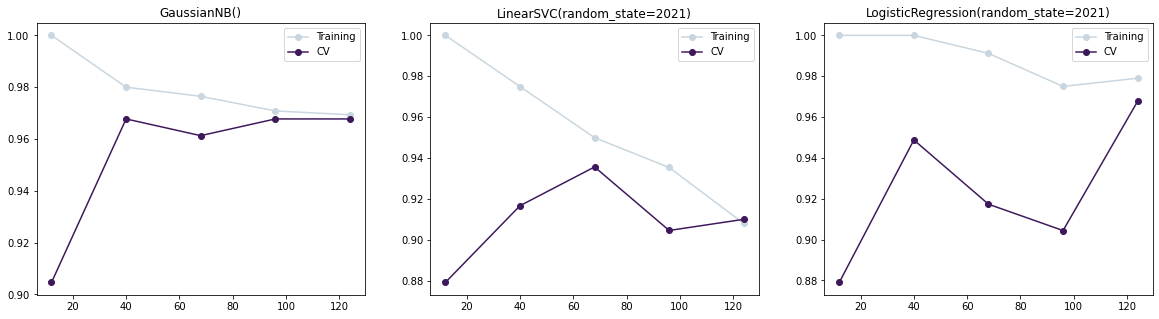

In [29]:
plot_learning(X_tc_train, y_tc_train)

### Feature Engineering

In [30]:
# Accuracy was not in percentage.
acc_cols = []

for col in clubstats.columns:
    if 'accuracy' in col:
        acc_cols.append(col)
        
clubstats_train[acc_cols] = clubstats_train[acc_cols] * 0.01

# Drop features that are not siginificantly different between two groups
drop_feat = ['aerial_battles', 'clearance', 'interceptions']
fe_tables = tables_train.drop(['position', 'drawn'], axis=1)
clubstats_train = clubstats_train.drop(drop_feat, axis=1)

#Create Tables + Clubstats dataset
tables_clubs = pd.concat([fe_tables.drop('is_top4',axis=1), clubstats_train.drop('season', axis=1)], axis=1)
tables_clubs = tables_clubs.drop(tables_clubs[tables_clubs['season'] < 2006].index, axis=0)

# Split Train and Test set
X_club_train, X_club_test, y_club_train, y_club_test = train_test_split(clubstats_train.drop('is_top4', axis=1), 
                                                                        clubstats_train['is_top4'], test_size=0.4, 
                                                                        random_state=2021, stratify=clubstats_train['is_top4'])
X_tc_train, X_tc_test, y_tc_train, y_tc_test = train_test_split(tables_clubs.drop('is_top4', axis=1), 
                                                                tables_clubs['is_top4'], test_size=0.4, 
                                                                random_state=2021, stratify=tables_clubs['is_top4'])

# Split Test set for validation set
X_club_valid, X_club_test, y_club_valid, y_club_test = train_test_split(X_club_test, y_club_test, 
                                                                        test_size=0.5, random_state=2021, 
                                                                        stratify=y_club_test)
X_tc_valid, X_tc_test, y_tc_valid, y_tc_test = train_test_split(X_tc_test, y_tc_test, 
                                                                test_size=0.5, random_state=2021, 
                                                                stratify=y_tc_test)

In [31]:
c_nb, c_lsvm, c_logit = train(X_club_train, y_club_train, X_club_valid, y_club_valid)

F1 Scores 
 Naive Bayes: 0.88 
 Linear SVM: 0.8695652173913043 
 Logitstic Regression: 0.9090909090909091


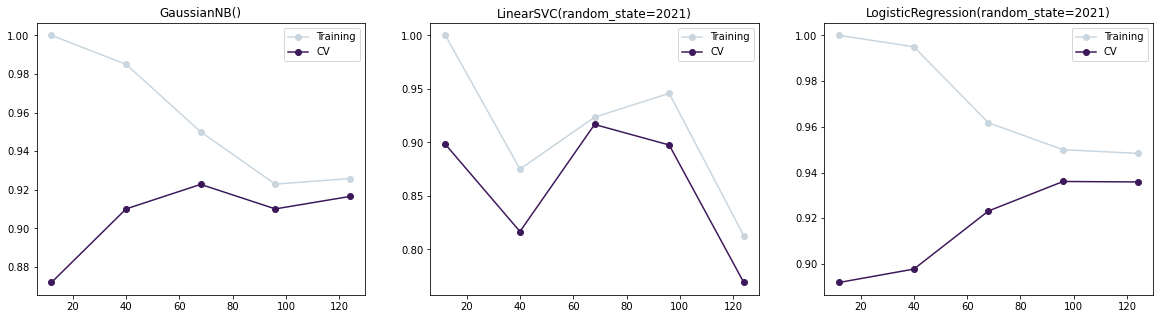

In [32]:
plot_learning(X_club_train, y_club_train)

In [33]:
tc_nb, tc_lsvm, tc_logit = train(X_tc_train, y_tc_train, X_tc_valid, y_tc_valid)

F1 Scores 
 Naive Bayes: 0.9565217391304348 
 Linear SVM: 0.625 
 Logitstic Regression: 1.0


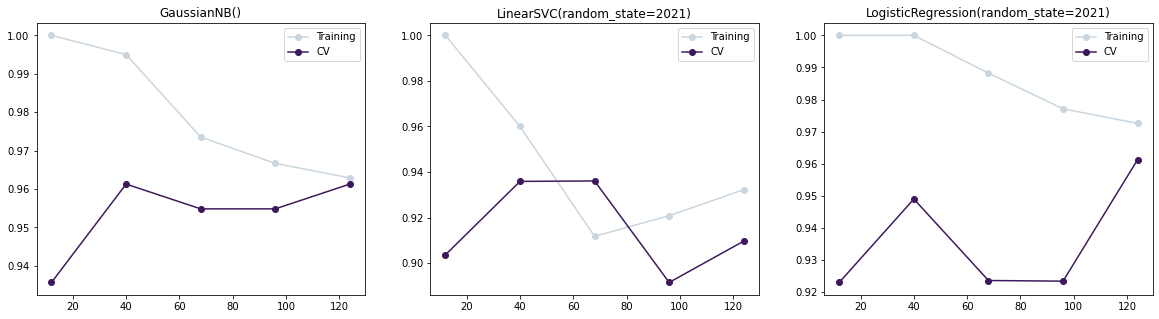

In [34]:
plot_learning(X_tc_train, y_tc_train)

### Prediction on the test set

In [35]:
# Real result from the offcial website: https://www.premierleague.com/tables?co=1&se=274&ha=-1
true_position = [1, 2, 5, 4, 3, 7, 9, 6, 8, 10, 14, 12, 13, 11, 15, 16, 19, 18, 17, 20]
y_test = [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [40]:
table_X = tables_test.drop(['is_top4', 'position', 'drawn'], axis=1)
club_X = clubstats_test.drop('is_top4', axis=1)

club_X[acc_cols] = club_X[acc_cols] * .01
club_X = club_X.drop(drop_feat, axis=1)
table_X = pd.concat([table_X, club_X.drop('season', axis=1)], axis=1)

In [41]:
print((f'F1 Score \n'
      f'tc_nb: {f1_score(y_test, tc_nb.predict(table_X))} \n'
      f'tc_logit: {f1_score(y_test, tc_logit.predict(table_X))} \n'
      f'c_nb: {f1_score(y_test, c_nb.predict(club_X))} \n'
      f'c_logit: {f1_score(y_test, c_logit.predict(club_X))}'))

F1 Score 
tc_nb: 0.5714285714285715 
tc_logit: 0.6666666666666666 
c_nb: 0.5714285714285715 
c_logit: 0.4


Dropped the lowest two models.

In [48]:
ave_preds = (tc_logit.predict_proba(table_X)[:, 1] + c_nb.predict_proba(club_X)[:, 1]) / 2

## Final Prediction table

In [49]:
final_table = current_season[['club_name', 'position']]

pd.concat([final_table, pd.Series(true_position, name='true_position'),
           pd.Series(ave_preds, name='ensemble_result'),
           pd.Series(y_test, name='is_top4')], axis=1)

,club_name,position,true_position,ensemble_result,is_top4
0,Liverpool,1,1,0.984733,1
1,Manchester City,2,2,0.973159,1
2,Leicester City,3,5,0.553860,0
3,Chelsea,4,4,0.336746,1
4,Manchester United,5,3,0.123626,1
5,Wolverhampton Wanderers,6,7,0.001299,0
6,Sheffield United,7,9,0.000343,0
7,Tottenham Hotspur,8,6,0.002260,0
8,Arsenal,9,8,0.001159,0
9,Burnley,10,10,0.000068,0


## Thoughts on prediction

There are nine games or ten games for some teams left to finish the 2019/20 season, which means that any team can get 27 or 30 points by winning the rest of the games. Therefore, there could be a lot of changes in the current standing. With many uncertainties, models was able to predicted descent result. Interestingly, the model generally give a higher percentage to the teams that are known for better teams than other(?) even though, they are in the lower position in the table. This shows that there are other key features that affects the result of the game.


## Limitations and others

Dataset does not include other features that might be important for performance of a team such as Team mentality, number of players who are injured, whether a team has world class players or not, etc… Therefore, there might be other important features that have a positive relationship with getting into the top 4. 